In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:00


# Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras import layers, models

# Data Loading

In [ ]:
import pandas as pd
import os

# Specify the folder where your CSV files are stored
data_path = '/content/drive/MyDrive/Lab Exam/har70plus'  # Update with the correct path

# List all CSV files in the directory
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Separate the test file (501.csv) and the rest for training
test_file = '501.csv'
train_files = [f for f in all_files if f != test_file]

# Load the test dataset (501.csv)
test_data = pd.read_csv(os.path.join(data_path, test_file))

# Load the training datasets (all files except 501.csv)
train_data_list = [pd.read_csv(os.path.join(data_path, file)) for file in train_files]

# Combine all training data into a single DataFrame
train_data = pd.concat(train_data_list, ignore_index=True)

# Show the first few rows of the test and training datasets
print("Test Data (501.csv):")
print(test_data.head())

print("\nTraining Data:")
print(train_data.head())


Test Data (501.csv):
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2021-03-24 14:42:03.839 -0.999023 -0.063477  0.140625 -0.980469 -0.112061   
1  2021-03-24 14:42:03.859 -0.980225 -0.079346  0.140625 -0.961182 -0.121582   
2  2021-03-24 14:42:03.880 -0.950195 -0.076416  0.140625 -0.949463 -0.080566   
3  2021-03-24 14:42:03.900 -0.954834 -0.059082  0.140381 -0.957520 -0.046143   
4  2021-03-24 14:42:03.920 -0.972412 -0.042969  0.142822 -0.977051 -0.023682   

    thigh_z  label  
0 -0.048096      6  
1 -0.051758      6  
2 -0.067139      6  
3 -0.050781      6  
4 -0.026611      6  

Training Data:
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2021-03-26 08:23:07.800 -1.009277 -0.153076 -0.280273 -1.040039 -0.118408   
1  2021-03-26 08:23:07.819 -0.971191 -0.122070 -0.255859 -1.108154  0.136719   
2  2021-03-26 08:23:07.840 -0.951660 -0.038574 -0.189697 -1.086914  0.156982   
3  2021-03-26 08:23:07.859 -0.930908

# Normalizing Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize accelerometer data using Z-Score Standardization
accelerometer_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply normalization to both training and testing data
train_data[accelerometer_columns] = scaler.fit_transform(train_data[accelerometer_columns])
test_data[accelerometer_columns] = scaler.transform(test_data[accelerometer_columns])

# Verify by printing the first few rows of the normalized data
print("\nNormalized Training Data:")
print(train_data[accelerometer_columns].head())

print("\nNormalized Test Data:")
print(test_data[accelerometer_columns].head())



Normalized Training Data:
     back_x    back_y    back_z   thigh_x   thigh_y   thigh_z
0 -0.527944 -0.799765 -0.703681 -0.666868 -0.457089  0.233391
1 -0.384187 -0.595936 -0.647351 -0.790996  0.469006  0.196113
2 -0.310467 -0.047044 -0.494695 -0.752290  0.542560  0.269712
3 -0.232138  0.155182 -0.306551 -0.636616 -0.006008  0.506762
4 -0.398013  0.078142 -0.258670 -0.542296 -0.553689  0.801641

Normalized Test Data:
     back_x    back_y    back_z   thigh_x   thigh_y   thigh_z
0 -0.489240 -0.210753  0.267456 -0.558312 -0.434050  0.663998
1 -0.418286 -0.315074  0.267456 -0.523165 -0.468610  0.656830
2 -0.304937 -0.295812  0.267456 -0.501809 -0.319725  0.626720
3 -0.322447 -0.181861  0.266893 -0.516491 -0.194772  0.658742
4 -0.388796 -0.075936  0.272525 -0.552083 -0.113240  0.706057


# Normalization of Sensor data

In [ ]:
# Normalize sensor data
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
scaler = MinMaxScaler()
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])

# Windowing to get features

In [ ]:
# Function to segment data into non-overlapping windows
def segment_windows(data, window_size=50):
    windows = []
    labels = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = data.iloc[i:i + window_size]
        windows.append(window[sensor_columns].values)
        labels.append(window['label'].mode()[0])  # Most frequent label
    return np.array(windows), np.array(labels)

# Segment training and testing data
X_train, y_train = segment_windows(train_data)
X_test, y_test = segment_windows(test_data)
print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of testing data:", X_test.shape, y_test.shape)

Shape of training data: (43114, 50, 6) (43114,)
Shape of testing data: (2077, 50, 6) (2077,)


In [ ]:
# Oversample to handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, 50, 6)  # Reshape back to original shape

# Check label distribution after oversampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Label distribution after oversampling:", dict(zip(unique, counts)))

Label distribution after oversampling: {1: 20360, 3: 20360, 4: 20360, 5: 20360, 6: 20360, 7: 20360, 8: 20360}


# Model Building

In [ ]:
# Define the CNN model
model = models.Sequential()

# 1st Conv1D Layer
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(50, 6)))
model.add(layers.MaxPooling1D(pool_size=2))

# 2nd Conv1D Layer
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# 3rd Conv1D Layer
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output from convolutional layers
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(256, activation='relu'))

# Output Layer (softmax for multi-class classification)
model.add(layers.Dense(7, activation='softmax'))  # 8 classes (activities)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy since labels are integers
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 48, 64)            1216      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 22, 128)           24704     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 11, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 9, 256)            98560     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 4, 256)           

# Training

Epoch 1/10
1348/1348 - 11s - loss: 0.4812 - accuracy: 0.8170 - val_loss: 0.2375 - val_accuracy: 0.9576 - 11s/epoch - 8ms/step
Epoch 2/10
1348/1348 - 10s - loss: 0.2628 - accuracy: 0.9182 - val_loss: 0.1235 - val_accuracy: 0.9687 - 10s/epoch - 8ms/step
Epoch 3/10
1348/1348 - 10s - loss: 0.2395 - accuracy: 0.9252 - val_loss: 0.1186 - val_accuracy: 0.9692 - 10s/epoch - 7ms/step
Epoch 4/10
1348/1348 - 10s - loss: 0.2262 - accuracy: 0.9297 - val_loss: 0.1311 - val_accuracy: 0.9658 - 10s/epoch - 7ms/step
Epoch 5/10
1348/1348 - 10s - loss: 0.2178 - accuracy: 0.9305 - val_loss: 0.1088 - val_accuracy: 0.9701 - 10s/epoch - 7ms/step
Epoch 6/10
1348/1348 - 10s - loss: 0.2106 - accuracy: 0.9313 - val_loss: 0.1063 - val_accuracy: 0.9701 - 10s/epoch - 7ms/step
Epoch 7/10
1348/1348 - 10s - loss: 0.2032 - accuracy: 0.9329 - val_loss: 0.1095 - val_accuracy: 0.9701 - 10s/epoch - 8ms/step
Epoch 8/10
1348/1348 - 10s - loss: 0.1921 - accuracy: 0.9344 - val_loss: 0.1140 - val_accuracy: 0.9692 - 10s/epoch - 7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


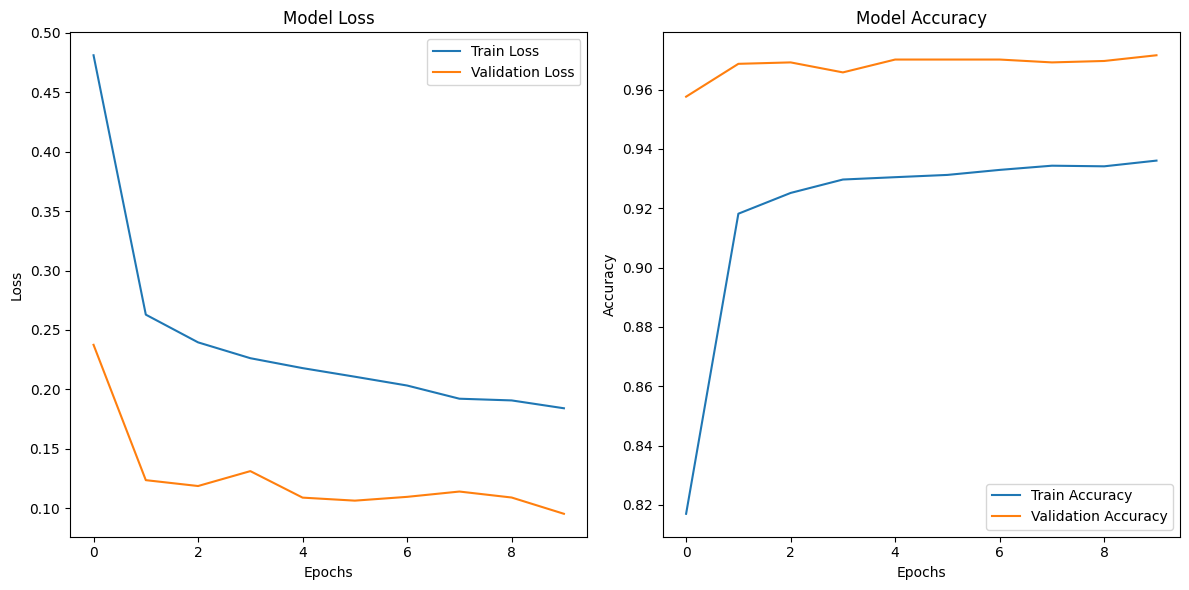

In [ ]:
# Train the model
history = model.fit(
    X_train,         # Training data
    y_train,         # Training labels
    epochs=10,       # Number of epochs (adjust as needed)
    batch_size=32,   # Batch size (adjust based on your system's memory)
    validation_data=(X_test, y_test),  # Validation data for monitoring performance
    verbose=2        # Print progress for each epoch
)

# Save the model after training (optional)
model.save('activity_recognition_cnn.h5')

# Display training history (loss and accuracy plots)
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Testing the model

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


65/65 - 0s - loss: 0.0952 - accuracy: 0.9716 - 234ms/epoch - 4ms/step
Test Loss: 0.0952
Test Accuracy: 0.9716


# Evaluation matrices

65/65 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98      1260
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.95      0.97      0.96       290
           6       1.00      1.00      1.00       291
           7       1.00      1.00      1.00       191

    accuracy                           0.97      2077
   macro avg       0.56      0.57      0.56      2077
weighted avg       0.95      0.97      0.96      2077



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


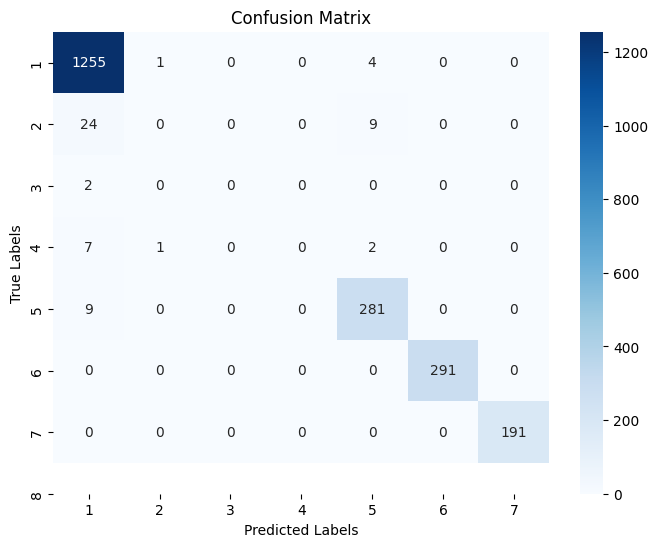

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test data
y_pred = model.predict(X_test)

# Convert predictions to class labels (using argmax for multi-class classification)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(1, 8)]))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 8)], yticklabels=[str(i) for i in range(1, 9)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
